# MultiVelo Fig3

We will use the embryonic E18 mouse brain from 10X Multiome as an example.

CellRanger output files can be downloaded from [10X website](https://www.10xgenomics.com/resources/datasets/fresh-embryonic-e-18-mouse-brain-5-k-1-standard-1-0-0). Crucially, the filtered feature barcode matrix folder, ATAC peak annotations TSV, and the feature linkage BEDPE file in the secondary analysis outputs folder will be needed in this demo. 

Quantified unspliced and spliced counts from Velocyto can be downloaded from [MultiVelo GitHub page](https://github.com/welch-lab/MultiVelo).

We provide the cell annotations for this dataset in "cell_annotations.tsv" on the GitHub page. (To download from GitHub, click on the file, then click "Raw" on the top right corner. If it opens in your browser, you can download the page as a text file.)

Weighted nearest neighbors from Seurat can be downloaded from GitHub folder "seurat_wnn", which contains a zip file of three files: "nn_cells.txt", "nn_dist.txt", and "nn_idx.txt". Please unzip the archive after downloading. The R script used to generate such files can also be found in the same folder.
```
.
|-- MultiVelo_Fig3.ipynb
|-- cell_annotations.tsv
|-- outs
|   |-- analysis
|   |   `-- feature_linkage
|   |       `-- feature_linkage.bedpe
|   |-- filtered_feature_bc_matrix
|   |   |-- barcodes.tsv.gz
|   |   |-- features.tsv.gz
|   |   `-- matrix.mtx.gz
|   `-- peak_annotation.tsv
|-- seurat_wnn
|   |-- nn_cells.txt
|   |-- nn_dist.txt
|   `-- nn_idx.txt
`-- velocyto
    `-- 10X_multiome_mouse_brain.loom
```

In [1]:
import os
import scipy
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import sys
import multivelo as mv
import matplotlib.pyplot as plt

['/Users/jake/Desktop/MultiVelo/multivelo_demo/fig3', '/Users/jake/opt/anaconda3/lib/python39.zip', '/Users/jake/opt/anaconda3/lib/python3.9', '/Users/jake/opt/anaconda3/lib/python3.9/lib-dynload', '', '/Users/jake/.local/lib/python3.9/site-packages', '/Users/jake/opt/anaconda3/lib/python3.9/site-packages', '/Users/jake/opt/anaconda3/lib/python3.9/site-packages/aeosa', '/Users/jake/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions', '/Users/jake/.ipython', '../src', '/Users/jake/pyWNN']


In [2]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
np.set_printoptions(suppress=True)

## Reading in unspliced and spliced counts

In [3]:
adata_rna = scv.read("velocyto/10X_multiome_mouse_brain.loom", cache=True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()

In [4]:
sc.pp.filter_cells(adata_rna, min_counts=1000)
sc.pp.filter_cells(adata_rna, max_counts=20000)

In [5]:
# Top 1000 variable genes are used for downstream analyses.
scv.pp.filter_and_normalize(adata_rna, min_shared_counts=10, n_top_genes=1000)

Filtered out 21580 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 1000 highly variable genes.
Logarithmized X.


In [6]:
# Load cell annotations
cell_annot = pd.read_csv('cell_annotations.tsv', sep='\t', index_col=0)

In [7]:
adata_rna = adata_rna[cell_annot.index,:]
adata_rna.obs['celltype'] = cell_annot['celltype']

In [8]:
# We subset for lineages towards neurons and astrocytes.
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['RG, Astro, OPC', 
                                                      'IPC', 
                                                      'V-SVZ', 
                                                      'Upper Layer', 
                                                      'Deeper Layer', 
                                                      'Ependymal cells', 
                                                      'Subplate'])]
adata_rna

View of AnnData object with n_obs × n_vars = 3653 × 1000
    obs: 'n_counts', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Preprocessing the ATAC counts

In [9]:
adata_atac = sc.read_10x_mtx('outs/filtered_feature_bc_matrix/', var_names='gene_symbols', cache=True, gex_only=False)
adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]

In [10]:
# We aggregate peaks around each gene as well as those that have high correlations with promoter peak or gene expression.
# Peak annotation contains the metadata for all peaks.
# Feature linkage contains pairs of correlated genomic features.
adata_atac = mv.aggregate_peaks_10x(adata_atac, 
                                    'outs/peak_annotation.tsv', 
                                    'outs/analysis/feature_linkage/feature_linkage.bedpe', 
                                    verbose=True)


CellRanger ARC identified as 1.0.0
Found 19006 genes with promoter peaks


  0%|          | 0/19006 [00:00<?, ?it/s]

In [12]:
sc.pp.filter_cells(adata_atac, min_counts=2000)
sc.pp.filter_cells(adata_atac, max_counts=60000)

In [13]:
# We normalize aggregated peaks with TF-IDF.
mv.tfidf_norm(adata_atac)

## Finding shared barcodes and features between RNA and ATAC

In [14]:
shared_cells = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac.obs_names))
shared_genes = pd.Index(np.intersect1d(adata_rna.var_names, adata_atac.var_names))
len(shared_cells), len(shared_genes)

(3365, 936)

In [15]:
# We reload in the raw data and continue with a subset of cells.
adata_rna = scv.read("velocyto/10X_multiome_mouse_brain.loom", cache=True)
adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
adata_rna.var_names_make_unique()

In [16]:
adata_rna = adata_rna[shared_cells, shared_genes]
adata_atac = adata_atac[shared_cells, shared_genes]

In [17]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [18]:
adata_rna.obs['celltype'] = cell_annot.loc[adata_rna.obs_names, 'celltype']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [19]:
# Reorder the categories for color consistency with the manuscript.
all_clusters = ['Upper Layer',
                'Deeper Layer',
                'V-SVZ',
                'RG, Astro, OPC',
                'Ependymal cells',
                'IPC',
                'Subplate']
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].cat.reorder_categories(all_clusters)

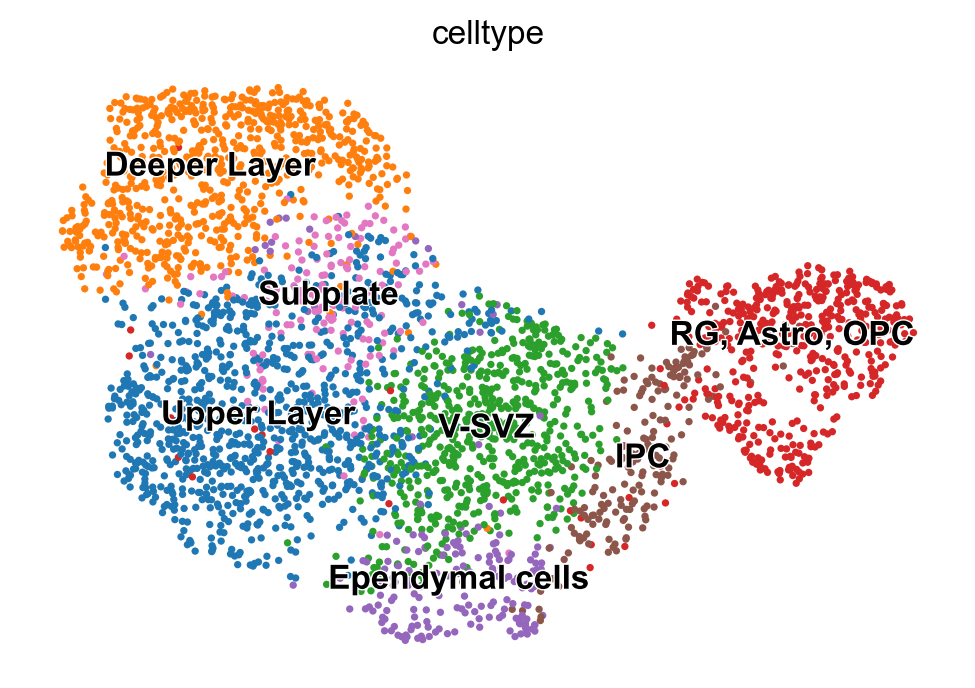

In [20]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype')

## Smoothing gene aggregagted peaks by neighbors

In [21]:
# Write out filtered cells and prepare to run Seurat WNN --> R script can be found on Github.
adata_rna.obs_names.to_frame().to_csv('filtered_cells.txt', header=False, index=False)

In [22]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("seurat_wnn/nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("seurat_wnn/nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("seurat_wnn/nn_cells.txt", header=None)[0])

print(nn_idx.shape)
#print(nn_idx)
#print(type(nn_idx))
print(nn_dist)
print()
print(nn_idx)
#print(type(nn_dist))

# Make sure cell names match.
np.all(nn_cells == adata_atac.obs_names)

(3365, 50)
[[0.17340591 0.22005092 0.23668469 ... 0.42222669 0.42259441 0.42498469]
 [0.01526168 0.18396344 0.20539438 ... 0.41339459 0.41574277 0.41630557]
 [0.17311608 0.25386041 0.26284482 ... 0.42351424 0.42411082 0.42676167]
 ...
 [0.06655001 0.23221774 0.23292968 ... 0.42737368 0.43086844 0.43166564]
 [0.00002872 0.28878217 0.29525615 ... 0.45620777 0.45628819 0.45924308]
 [0.17845804 0.18427957 0.22918548 ... 0.45052656 0.45191771 0.45210676]]

[[ 897. 1248.  709. ... 1762. 1739. 2239.]
 [2100. 1003. 1706. ... 1860. 1022.   20.]
 [ 238. 3093. 1655. ...  237.  235. 1781.]
 ...
 [ 450. 3156. 2857. ... 2218.  627. 1083.]
 [2951. 1042. 1881. ... 2181. 3269.  238.]
 [2834. 2105.  480. ...  836. 1628.  829.]]


True

In [23]:
mv.knn_smooth_chrom(adata_atac, nn_idx, nn_dist)

In [24]:
print(adata_rna.uns.keys())
adata_atac

odict_keys(['pca', 'neighbors', 'umap', 'celltype_colors'])


AnnData object with n_obs × n_vars = 3365 × 936
    obs: 'n_counts'
    layers: 'Mc'
    obsp: 'connectivities'

## Running multi-omic dynamical model

MultiVelo incorporates chromatin accessibility information into RNA velocity and achieves better lineage predictions.

The detailed argument list can be shown with "help(mv.recover_dynamics_chrom)".

recovering dynamics (using 1/10 cores)


  0%|          | 0/850 [00:00<?, ?gene/s]

    finished (0:05:03) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:02) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/10 cores)


  0%|          | 0/3365 [00:00<?, ?cells/s]

    finished (0:00:15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


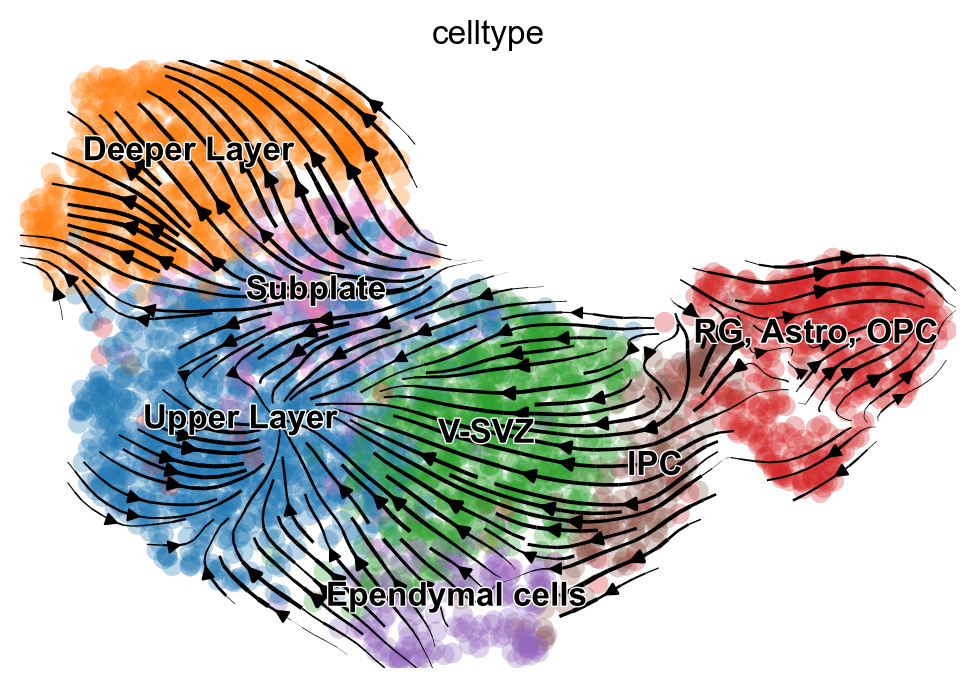

In [25]:
scv.tl.recover_dynamics(adata_rna)
scv.tl.velocity(adata_rna, mode="dynamical")
scv.tl.velocity_graph(adata_rna, n_jobs=1)
scv.tl.latent_time(adata_rna)
scv.pl.velocity_embedding_stream(adata_rna, basis='umap', color='celltype')

In [26]:
# This will take a while. Parallelization is high recommended.

adata_result = mv.recover_dynamics_chrom(adata_rna, 
                                        adata_atac,
                                        #gene_list = adata_rna.var_names[adata_rna.var['velocity_genes']],
                                        max_iter=5, 
                                        init_mode="invert", 
                                        verbose=False,
#                                         parallel=True,
#                                         n_jobs = 2,
                                        parallel=False,
                                        save_plot=False,
                                        rna_only=False,
                                        fit=True,
                                        n_anchors=500, 
                                        extra_color_key='celltype'
                                        )


  0%|          | 0/936 [00:00<?, ?it/s]

In [27]:
# Save the result for use later on
adata_result.write("multivelo_result_fig3.h5ad")

In [28]:
adata_result = sc.read_h5ad("multivelo_result_fig3.h5ad")

## Computing velocity stream and latent time

In [29]:
print(adata_result)

AnnData object with n_obs × n_vars = 3365 × 865
    obs: 'n_counts', 'celltype', 'velocity_self_transition', 'root_cells', 'end_points', 'velocity_pseudotime', 'latent_time'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes', 'fit_alpha_c', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes'
    uns: 'celltype_colors', 'neighbors', 'pca', 'recover_dynamics', 'umap', 'velo_chrom_params', 'velo_s_params', 'velo_u_params', 'velocity_graph', 'velocity_graph_n

In [30]:
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

computing velocity graph (using 1/10 cores)


  0%|          | 0/3365 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


# Fig 3a

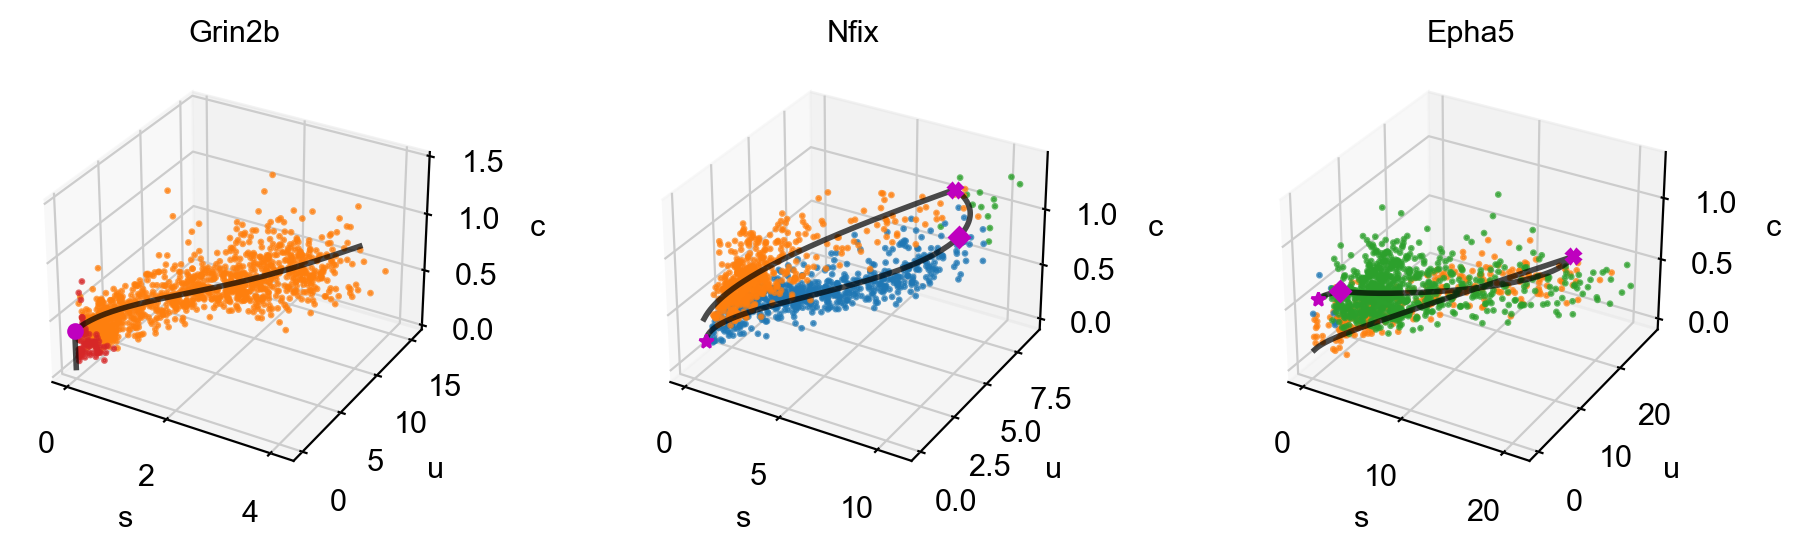

In [31]:
gene_list = ["Grin2b", "Nfix", "Epha5"]
mv.scatter_plot(adata_result, by='cus', n_cols=3, color_by='state', downsample=3, show_anchors=True, genes=gene_list)

# Fig 3b

<Figure size 600x400 with 0 Axes>

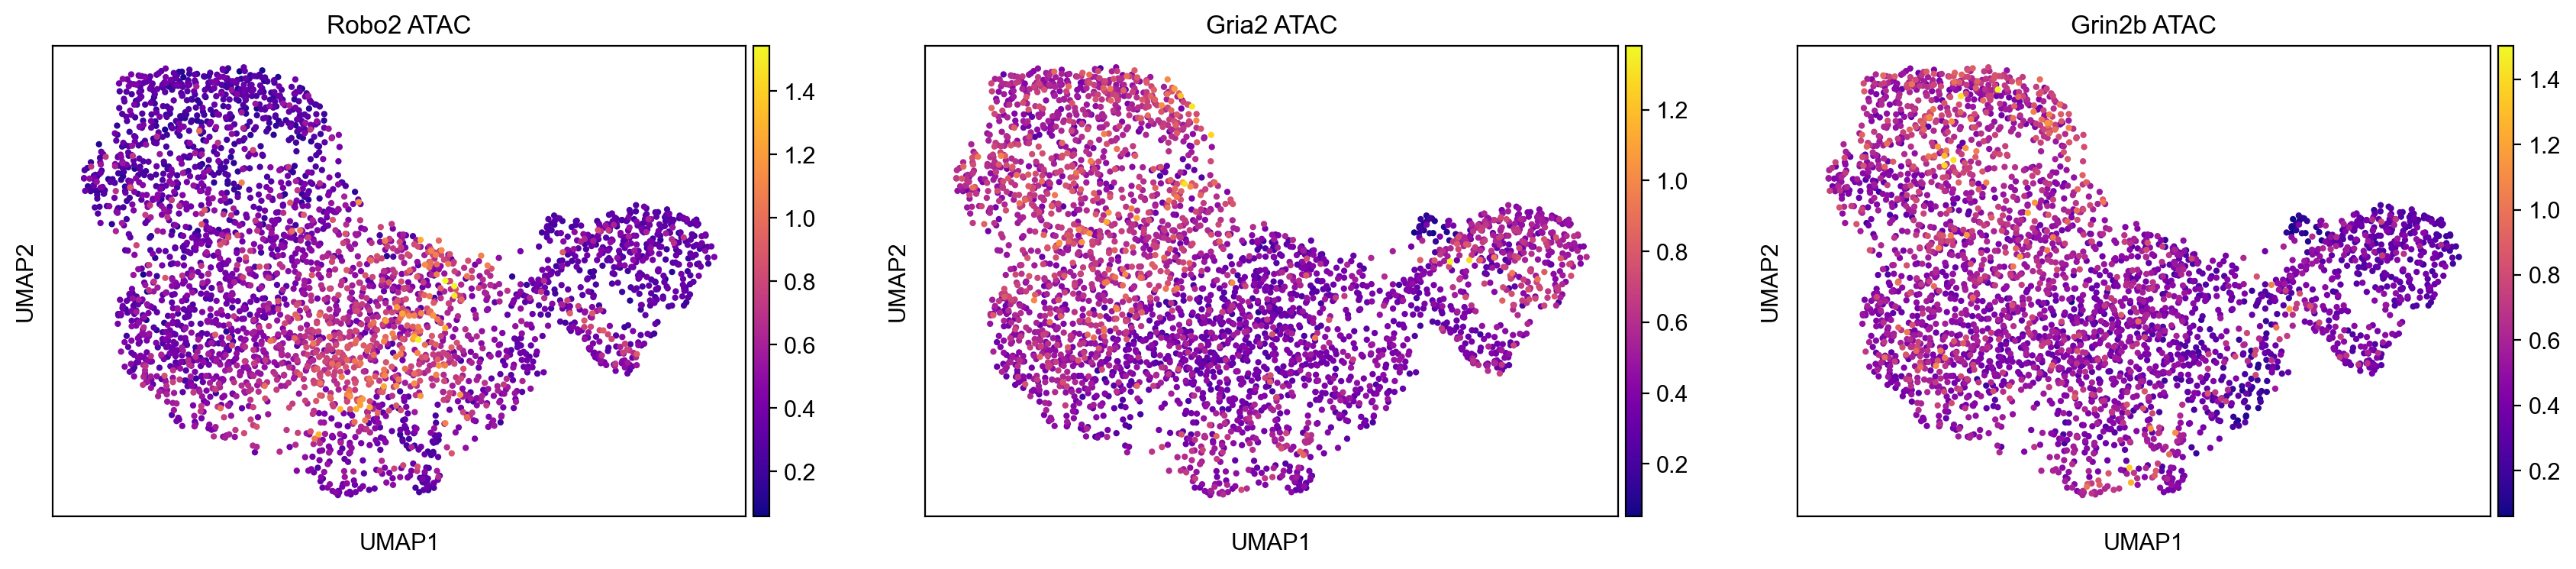

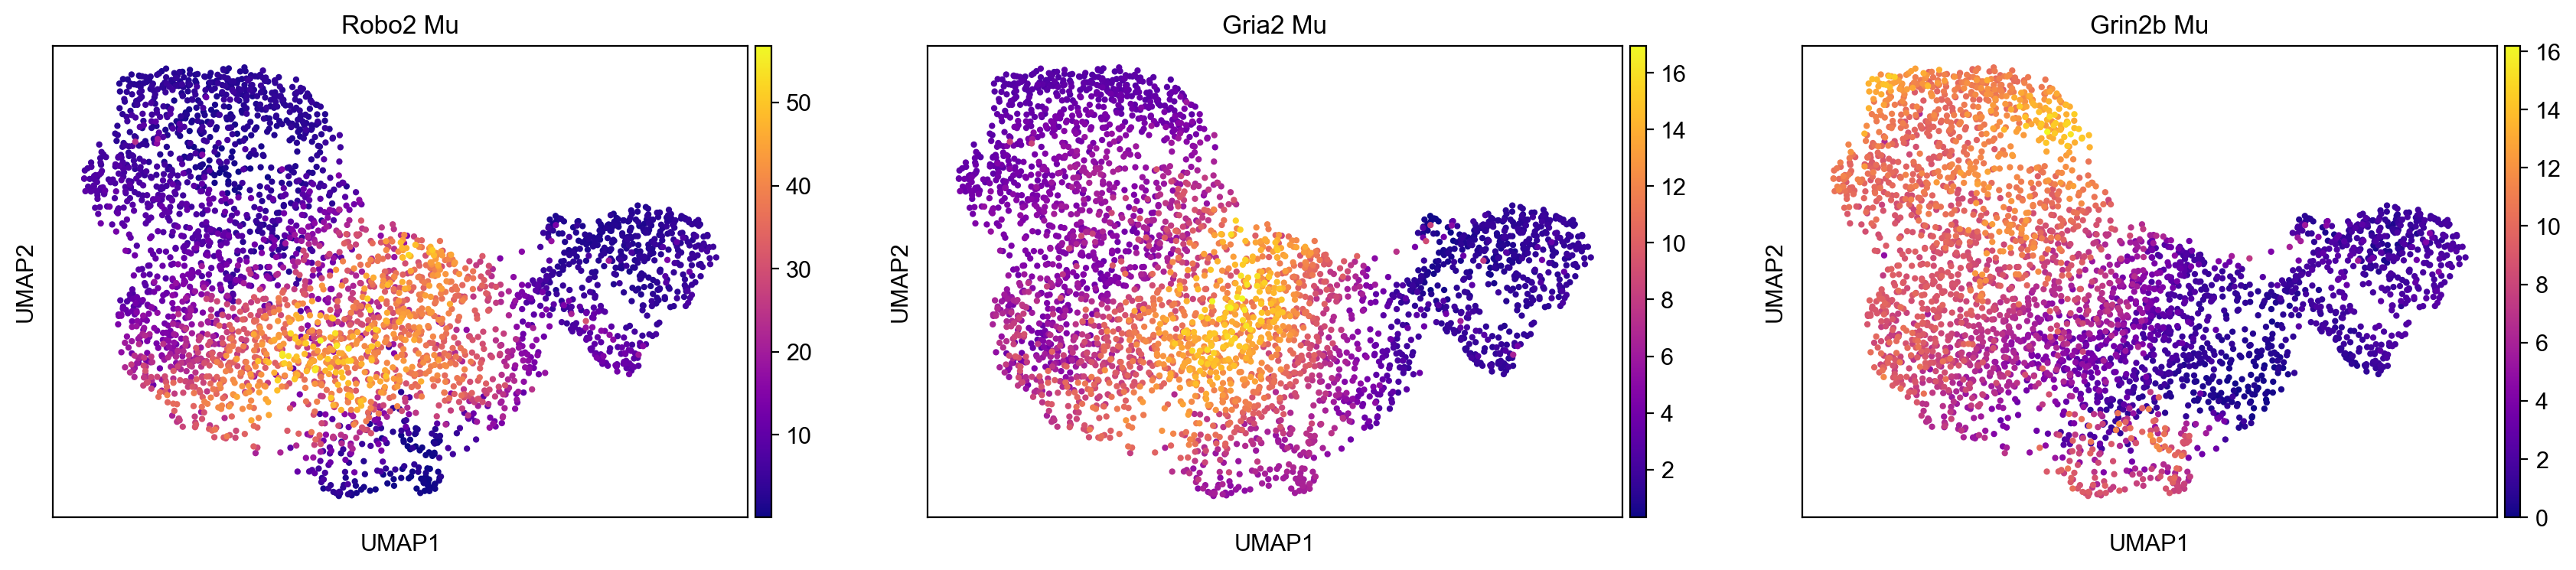

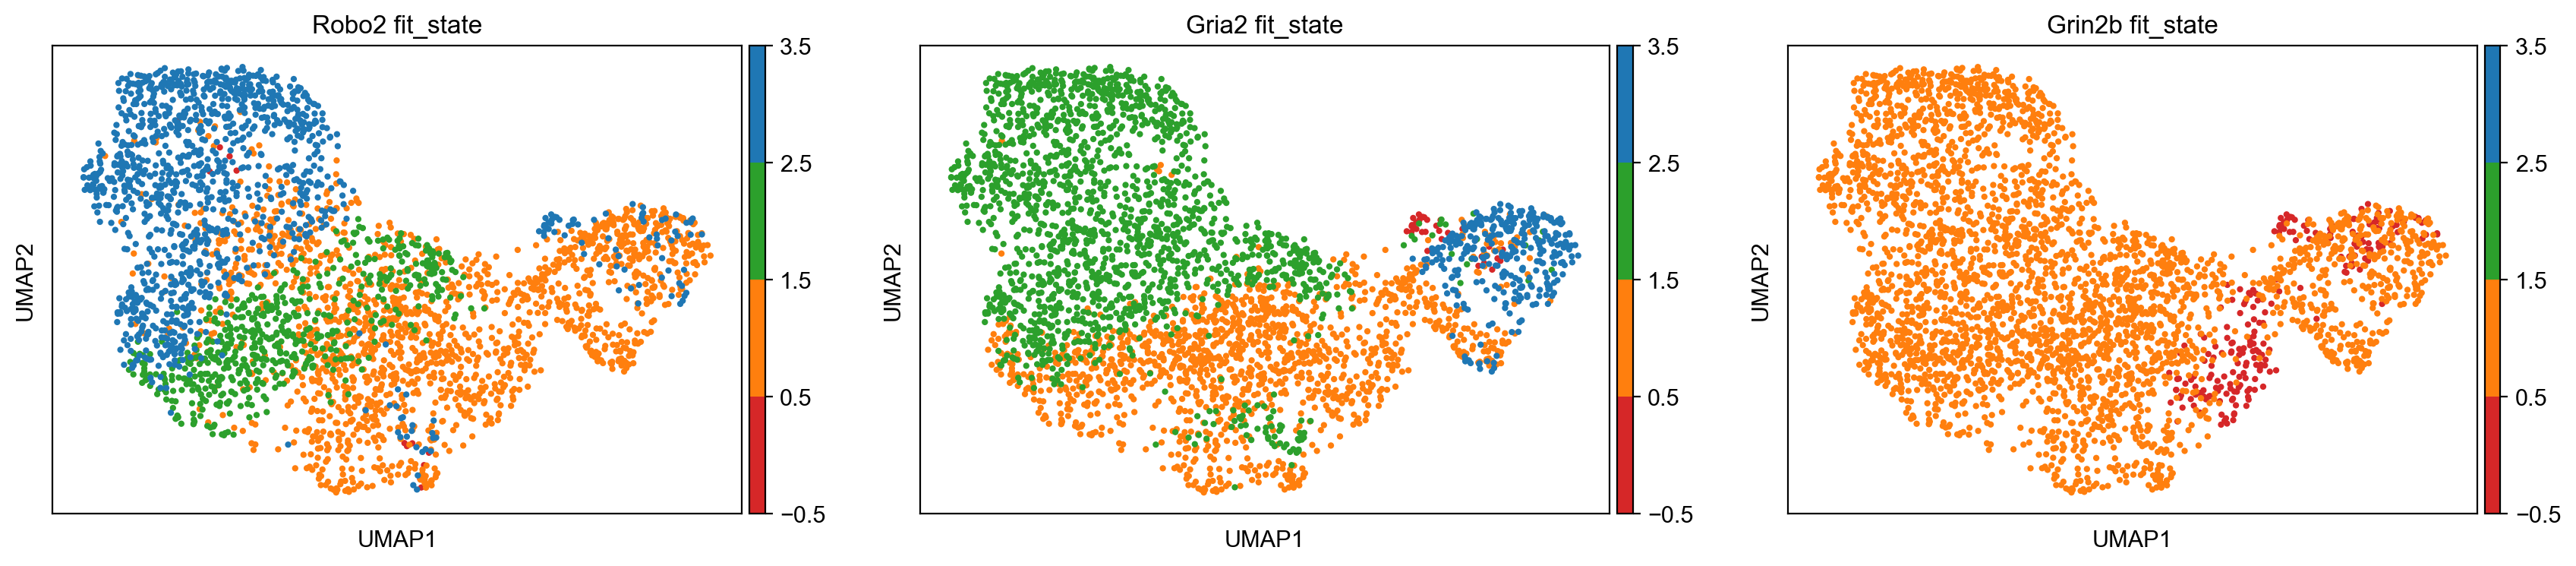

In [83]:
from matplotlib import colors
cmap = colors.ListedColormap(['tab:red', 'tab:orange', 'tab:green', 'tab:blue'])
bounds=[-0.5,0.5,1.5,2.5,3.5]
norm = colors.BoundaryNorm(bounds, cmap.N)

genes = ["Robo2", "Gria2", "Grin2b"]
layers = ["ATAC", "Mu", "fit_state"]
colors = ["plasma", "plasma", cmap]
norms = [None, None, norm]

plt.figure()

i = 0

for layer in layers:
    titles = []
    for gene in genes:
        titles.append(gene + " " + layer)
    
    sc.pl.umap(adata_result, color=genes, layer=layer, color_map=colors[i], title=titles, norm=norms[i])
    i += 1
    

# Fig 3c

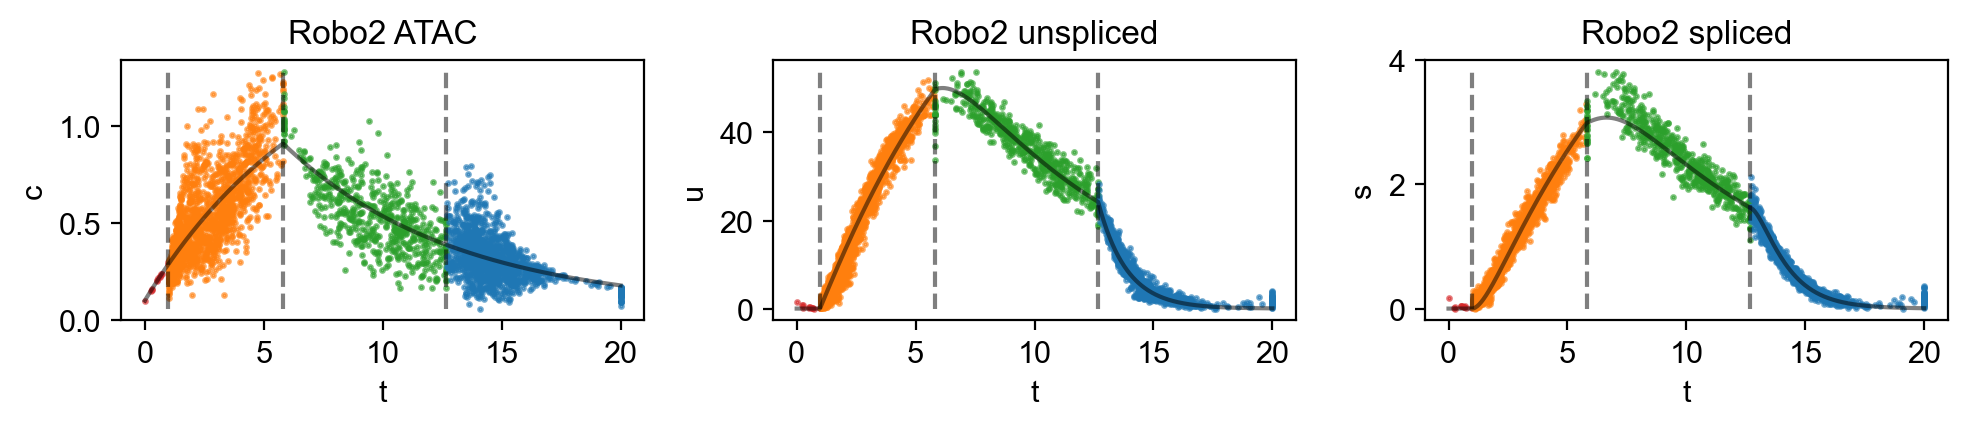

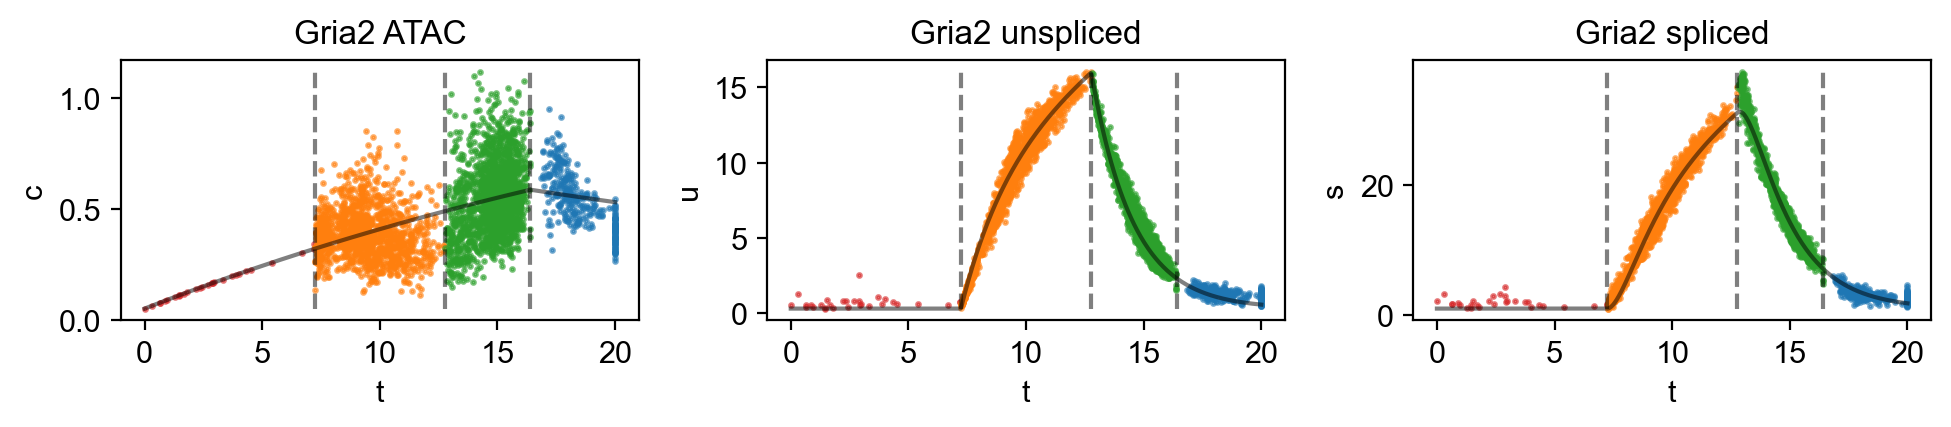

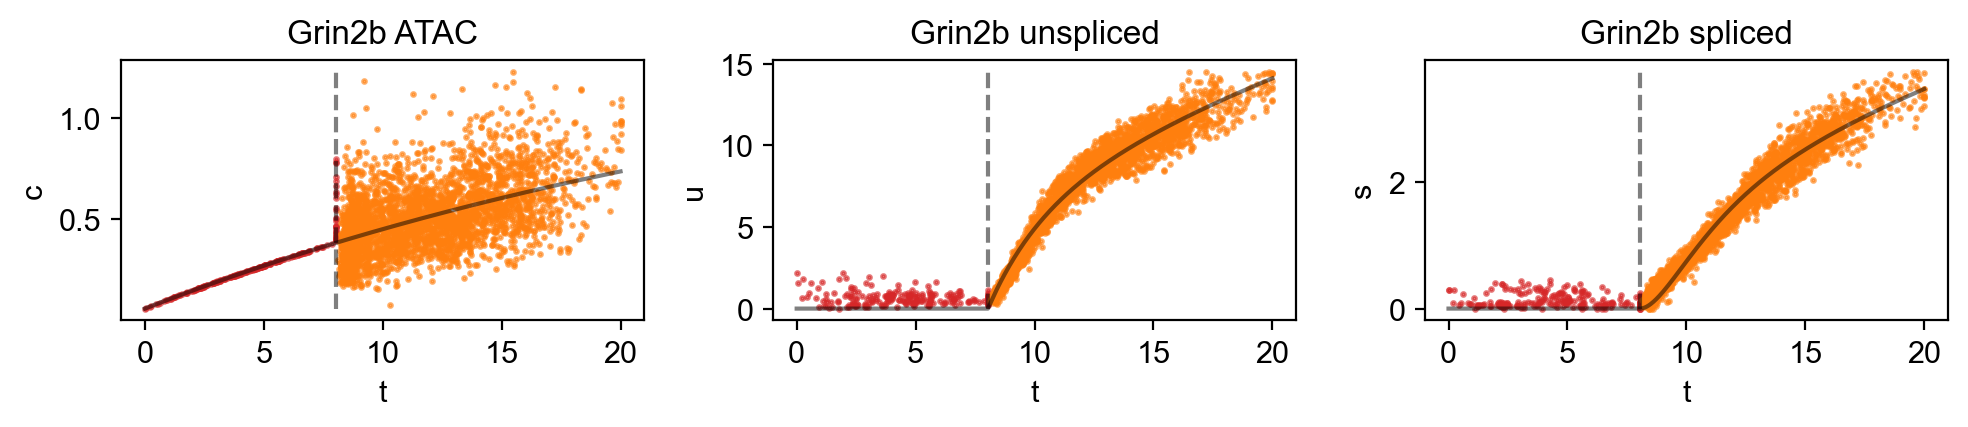

In [33]:
mv.dynamic_plot(adata_result, genes=["Robo2"], color_by="state")
mv.dynamic_plot(adata_result, genes=["Gria2"], color_by="state")
mv.dynamic_plot(adata_result, genes=["Grin2b"], color_by="state")

# Fig 3d

In [34]:
sc.tl.leiden(adata_result)

In [35]:
neuron_genes = np.mean(adata_result[adata_result.obs['celltype'] != 'RG, Astro, OPC',:].X.A, axis=0) > np.mean(adata_result[adata_result.obs['celltype'] == 'RG, Astro, OPC',:].X.A, axis=0)
adata_result.obs['state0 count'] = np.sum((adata_result[:,adata_result.var['velo_s_genes'] & neuron_genes].layers['fit_state'] == 0), axis=1)
adata_result.obs['state1 count'] = np.sum((adata_result[:,adata_result.var['velo_s_genes'] & neuron_genes].layers['fit_state'] == 1), axis=1)
adata_result.obs['state2 count'] = np.sum((adata_result[:,adata_result.var['velo_s_genes'] & neuron_genes].layers['fit_state'] == 2), axis=1)
adata_result.obs['state3 count'] = np.sum((adata_result[:,adata_result.var['velo_s_genes'] & neuron_genes].layers['fit_state'] == 3), axis=1)
adata_result.obs['state0 count'] /= np.max(adata_result.obs['state0 count'])
adata_result.obs['state1 count'] /= np.max(adata_result.obs['state1 count'])
adata_result.obs['state2 count'] /= np.max(adata_result.obs['state2 count'])
adata_result.obs['state3 count'] /= np.max(adata_result.obs['state3 count'])

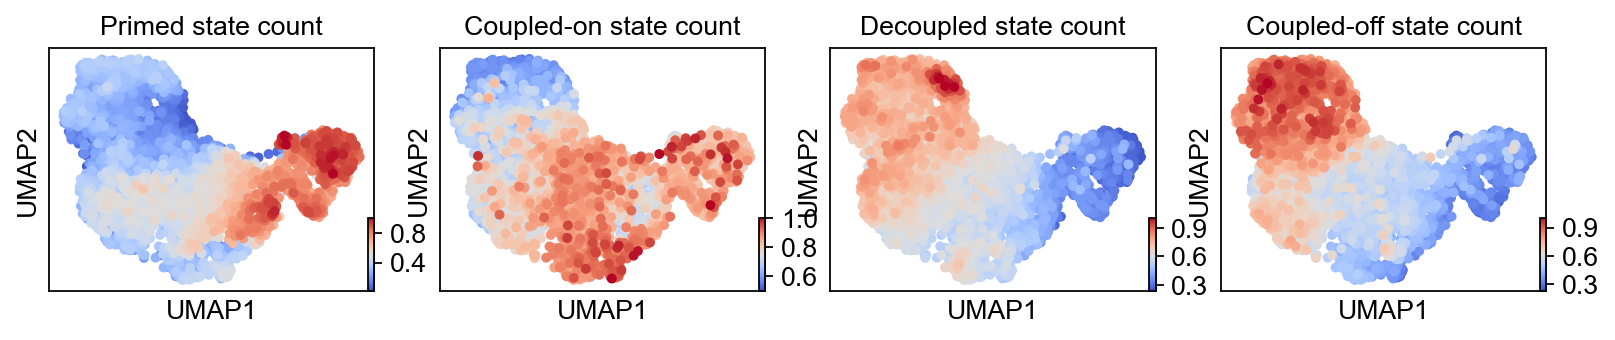

In [39]:
colors = ['state0 count','state1 count','state2 count','state3 count']
titles = ['Primed state count', "Coupled-on state count", "Decoupled state count", "Coupled-off state count"]
scv.pl.scatter(adata_result, color=colors, size=80, frameon=True, color_map="coolwarm", title=titles)

# Fig 3e

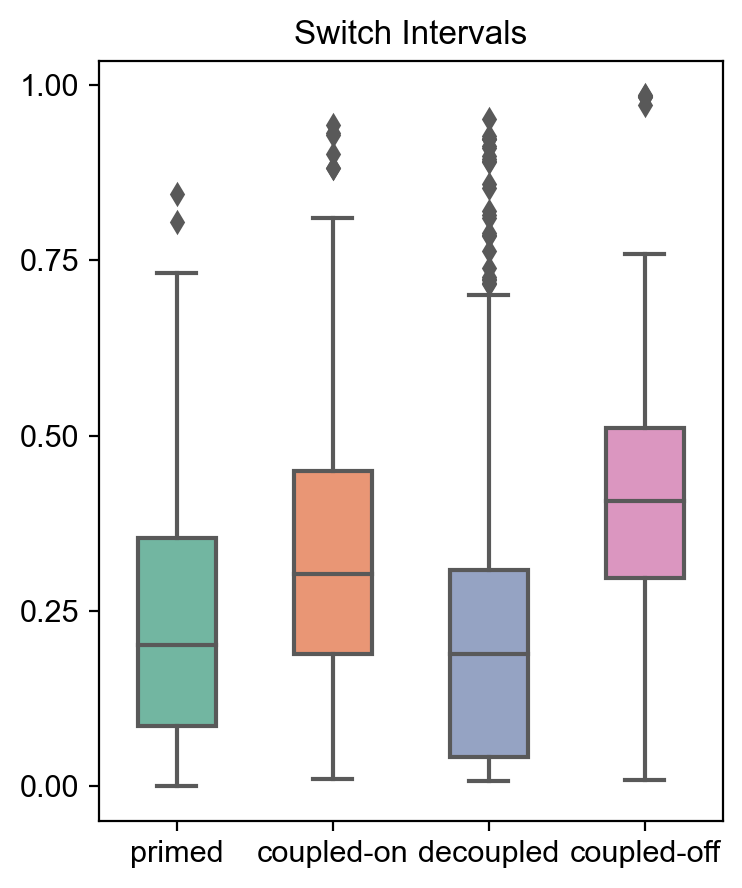

In [37]:
mv.switch_time_summary(adata_result)

# Fig 3f

{'whiskers': [<matplotlib.lines.Line2D at 0x7fd4d9da2d30>,
 'caps': [<matplotlib.lines.Line2D at 0x7fd4d9da20d0>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7fd4b8a91e80>],
 'medians': [<matplotlib.lines.Line2D at 0x7fd4d9da23a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fd4d9da2b80>],
 'means': []}

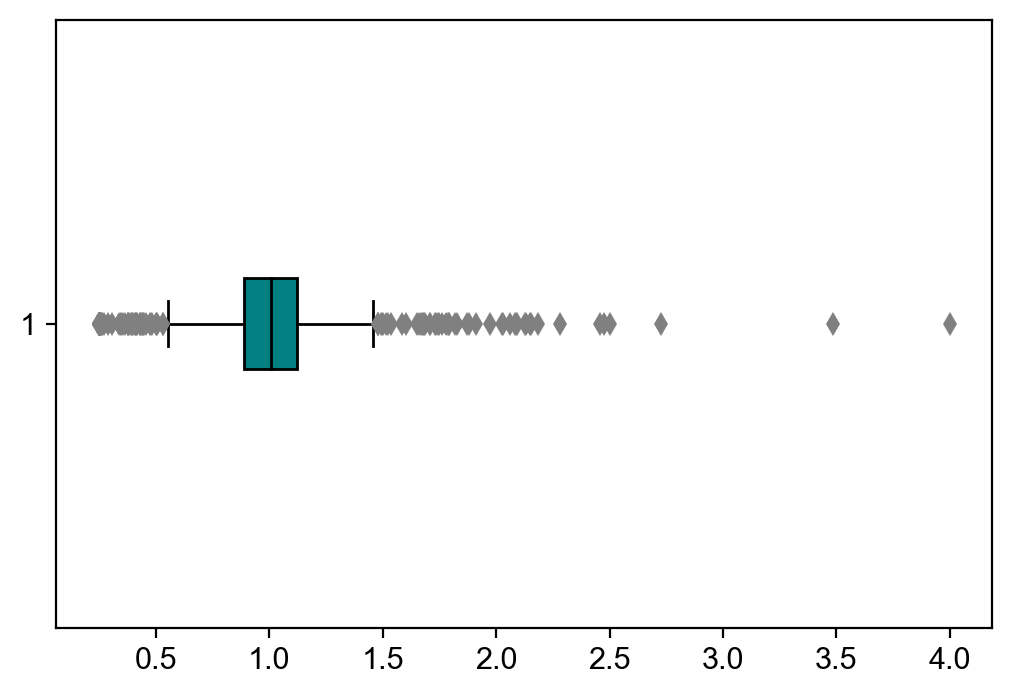

In [38]:
plt.boxplot(adata_result.var["fit_scale_cc"], vert=False, patch_artist=True,
            boxprops=dict(facecolor='teal'),
            medianprops=dict(color="black"),
            flierprops=dict(markerfacecolor='grey', marker='d', fillstyle="full", markeredgewidth=0.0))